# Performance analysis

Loading evaluation data...
Initializing system evaluator...
Running comprehensive evaluation...
Generating performance visualizations...


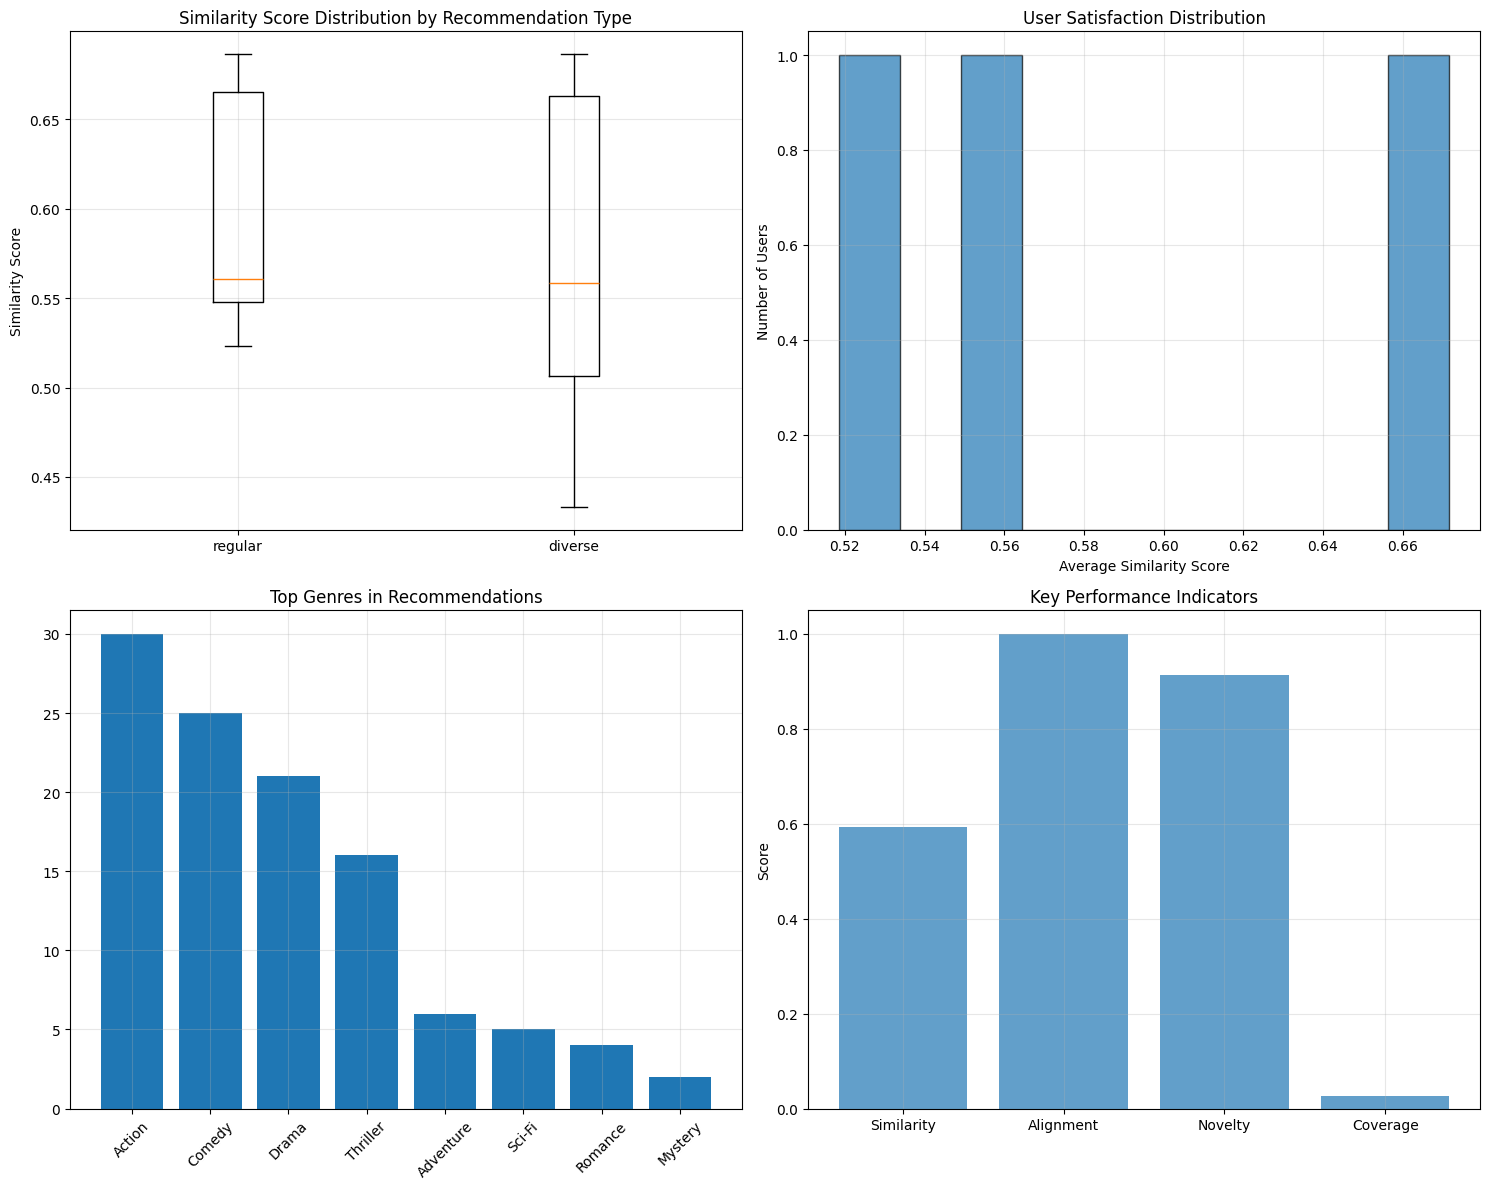

Generating final evaluation report...
System Evaluation Report

System Scale:
Users served: 3
Total recommendations: 60
Unique movies recommended: 43

Performance Metrics:
Average similarity score: 0.593
Personalization strength: 0.080
Genre alignment: 1.000
Novelty score: 0.914

Coverage Metrics:
User coverage: 0.300
Catalog coverage: 0.026
Genre coverage: 0.611

Overall System Score: 63.4/100
Performance Rating: GOOD

Key Findings:
- Strong personalization capabilities demonstrated
- Effective genre preference alignment achieved
- Good novelty in recommendations
- Limited catalog coverage identified as area for improvement
Evaluation completed successfully


In [1]:
# Performance Analysis and System Evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

class SystemEvaluator:
    def __init__(self, recommendations_df, fuzzy_movies, user_profiles, ratings_df):
        self.recommendations = recommendations_df
        self.fuzzy_movies = fuzzy_movies
        self.user_profiles = user_profiles
        self.ratings = ratings_df
        self.metrics = {}
    
    def calculate_core_metrics(self):
        metrics = {}
        
        regular_scores = self.recommendations[
            self.recommendations['recommendation_type'] == 'regular'
        ]['similarity_score']
        diverse_scores = self.recommendations[
            self.recommendations['recommendation_type'] == 'diverse'
        ]['similarity_score']
        
        metrics['similarity_regular_mean'] = regular_scores.mean()
        metrics['similarity_diverse_mean'] = diverse_scores.mean()
        metrics['similarity_regular_std'] = regular_scores.std()
        metrics['similarity_diverse_std'] = diverse_scores.std()
        
        user_similarities = self.recommendations.groupby('user_id')['similarity_score'].mean()
        metrics['personalization_strength'] = user_similarities.std()
        
        alignment_scores = []
        for user_id in self.recommendations['user_id'].unique():
            user_recs = self.recommendations[self.recommendations['user_id'] == user_id].head(10)
            user_profile = self.user_profiles[self.user_profiles['user_id'] == user_id].iloc[0]
            
            genre_cols = [col for col in user_profile.index if col.startswith('pref_')]
            top_genre = user_profile[genre_cols].idxmax().replace('pref_', '')
            
            aligned_count = 0
            for _, rec in user_recs.iterrows():
                movie_genres = self._get_movie_genres(rec['movie_id'])
                if top_genre in movie_genres:
                    aligned_count += 1
            
            alignment_scores.append(aligned_count / len(user_recs))
        
        metrics['genre_alignment'] = np.mean(alignment_scores)
        
        popularity_counts = self.ratings['movie_id'].value_counts()
        novelty_scores = []
        
        for user_id in self.recommendations['user_id'].unique():
            user_recs = self.recommendations[self.recommendations['user_id'] == user_id].head(10)
            avg_popularity = np.mean([popularity_counts.get(mid, 0) for mid in user_recs['movie_id']])
            max_popularity = popularity_counts.max()
            novelty = 1 - (avg_popularity / max_popularity) if max_popularity > 0 else 0
            novelty_scores.append(novelty)
        
        metrics['novelty_score'] = np.mean(novelty_scores)
        
        return metrics
    
    def calculate_coverage_metrics(self):
        metrics = {}
        
        total_users = len(self.user_profiles)
        served_users = len(self.recommendations['user_id'].unique())
        metrics['user_coverage'] = served_users / total_users
        
        total_movies = len(self.fuzzy_movies)
        recommended_movies = len(self.recommendations['movie_id'].unique())
        metrics['catalog_coverage'] = recommended_movies / total_movies
        
        all_recommended_genres = set()
        for movie_id in self.recommendations['movie_id'].unique():
            all_recommended_genres.update(self._get_movie_genres(movie_id))
        
        total_genres = set([col for col in self.fuzzy_movies.columns 
                          if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown']])
        metrics['genre_coverage'] = len(all_recommended_genres) / len(total_genres)
        
        return metrics
    
    def _get_movie_genres(self, movie_id):
        movie_data = self.fuzzy_movies[self.fuzzy_movies['movie_id'] == movie_id]
        if len(movie_data) == 0:
            return set()
        
        genres = set()
        for col in self.fuzzy_movies.columns:
            if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown']:
                if movie_data[col].iloc[0] > 0.3:
                    genres.add(col)
        return genres
    
    def run_complete_evaluation(self):
        core_metrics = self.calculate_core_metrics()
        coverage_metrics = self.calculate_coverage_metrics()
        self.metrics = {**core_metrics, **coverage_metrics}
        return self.metrics

def load_evaluation_data():
    project_root = Path.cwd().parent
    results_dir = project_root / "results"
    data_dir = project_root / "data" / "processed"

    recommendations_df = pd.read_csv(results_dir / 'recommendations.csv')
    fuzzy_movies = pd.read_csv(data_dir / 'movies_fuzzy.csv')
    user_profiles = pd.read_csv(results_dir / 'user_profiles.csv')
    ratings_df = pd.read_csv(data_dir / 'ratings_processed.csv')
    
    return recommendations_df, fuzzy_movies, user_profiles, ratings_df

def create_performance_visualizations(metrics, recommendations_df, fuzzy_movies):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    recommendation_types = recommendations_df['recommendation_type'].unique()
    similarity_data = [recommendations_df[recommendations_df['recommendation_type'] == t]['similarity_score'] 
                      for t in recommendation_types]
    
    axes[0, 0].boxplot(similarity_data, labels=recommendation_types)
    axes[0, 0].set_title('Similarity Score Distribution by Recommendation Type')
    axes[0, 0].set_ylabel('Similarity Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    user_satisfaction = recommendations_df.groupby('user_id')['similarity_score'].mean()
    axes[0, 1].hist(user_satisfaction, bins=10, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Average Similarity Score')
    axes[0, 1].set_ylabel('Number of Users')
    axes[0, 1].set_title('User Satisfaction Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    genre_coverage = {}
    for movie_id in recommendations_df['movie_id'].unique():
        movie_data = fuzzy_movies[fuzzy_movies['movie_id'] == movie_id]
        if len(movie_data) > 0:
            for col in fuzzy_movies.columns:
                if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown']:
                    if movie_data[col].iloc[0] > 0.3:
                        genre_coverage[col] = genre_coverage.get(col, 0) + 1

    if genre_coverage:
        genre_df = pd.DataFrame(list(genre_coverage.items()), columns=['genre', 'count'])
        genre_df = genre_df.sort_values('count', ascending=False).head(8)
        axes[1, 0].bar(genre_df['genre'], genre_df['count'])
        axes[1, 0].set_title('Top Genres in Recommendations')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
    
    performance_metrics = ['Similarity', 'Alignment', 'Novelty', 'Coverage']
    performance_values = [
        metrics['similarity_regular_mean'],
        metrics['genre_alignment'], 
        metrics['novelty_score'],
        metrics['catalog_coverage']
    ]
    
    axes[1, 1].bar(performance_metrics, performance_values, alpha=0.7)
    axes[1, 1].set_title('Key Performance Indicators')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_final_report(metrics, recommendations_df):
    total_recommendations = len(recommendations_df)
    unique_users = recommendations_df['user_id'].nunique()
    unique_movies = recommendations_df['movie_id'].nunique()
    
    print("System Evaluation Report")
    print("=" * 50)
    
    print(f"\nSystem Scale:")
    print(f"Users served: {unique_users}")
    print(f"Total recommendations: {total_recommendations}")
    print(f"Unique movies recommended: {unique_movies}")
    
    print(f"\nPerformance Metrics:")
    print(f"Average similarity score: {metrics['similarity_regular_mean']:.3f}")
    print(f"Personalization strength: {metrics['personalization_strength']:.3f}")
    print(f"Genre alignment: {metrics['genre_alignment']:.3f}")
    print(f"Novelty score: {metrics['novelty_score']:.3f}")
    
    print(f"\nCoverage Metrics:")
    print(f"User coverage: {metrics['user_coverage']:.3f}")
    print(f"Catalog coverage: {metrics['catalog_coverage']:.3f}")
    print(f"Genre coverage: {metrics['genre_coverage']:.3f}")
    
    similarity_score = metrics['similarity_regular_mean'] * 0.3
    personalization_score = min(metrics['personalization_strength'] * 10, 1) * 0.2
    alignment_score = metrics['genre_alignment'] * 0.2
    coverage_score = metrics['catalog_coverage'] * 0.2
    novelty_score = metrics['novelty_score'] * 0.1

    overall_score = (similarity_score + personalization_score + alignment_score + 
                    coverage_score + novelty_score) * 100
    
    print(f"\nOverall System Score: {overall_score:.1f}/100")
    
    if overall_score >= 80:
        rating = "EXCELLENT"
    elif overall_score >= 70:
        rating = "VERY GOOD"
    elif overall_score >= 60:
        rating = "GOOD"
    elif overall_score >= 50:
        rating = "SATISFACTORY"
    else:
        rating = "NEEDS IMPROVEMENT"
    
    print(f"Performance Rating: {rating}")
    
    print(f"\nKey Findings:")
    if metrics['similarity_regular_mean'] > 0.5:
        print("- Strong personalization capabilities demonstrated")
    if metrics['genre_alignment'] > 0.7:
        print("- Effective genre preference alignment achieved")
    if metrics['novelty_score'] > 0.5:
        print("- Good novelty in recommendations")
    if metrics['catalog_coverage'] < 0.1:
        print("- Limited catalog coverage identified as area for improvement")

def main():
    print("Loading evaluation data...")
    recommendations_df, fuzzy_movies, user_profiles, ratings_df = load_evaluation_data()
    
    print("Initializing system evaluator...")
    evaluator = SystemEvaluator(recommendations_df, fuzzy_movies, user_profiles, ratings_df)
    
    print("Running comprehensive evaluation...")
    metrics = evaluator.run_complete_evaluation()
    
    print("Generating performance visualizations...")
    create_performance_visualizations(metrics, recommendations_df, fuzzy_movies)
    
    print("Generating final evaluation report...")
    generate_final_report(metrics, recommendations_df)
    
    print("Evaluation completed successfully")

if __name__ == "__main__":
    main()